In [1]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import gdown
import matplotlib.pyplot as plt



🧑 Showing facial expressions for: Aubert


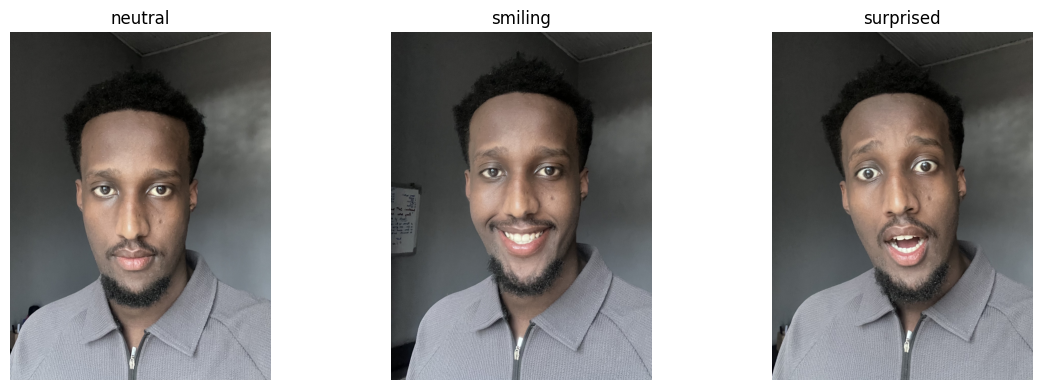


🧑 Showing facial expressions for: Jade


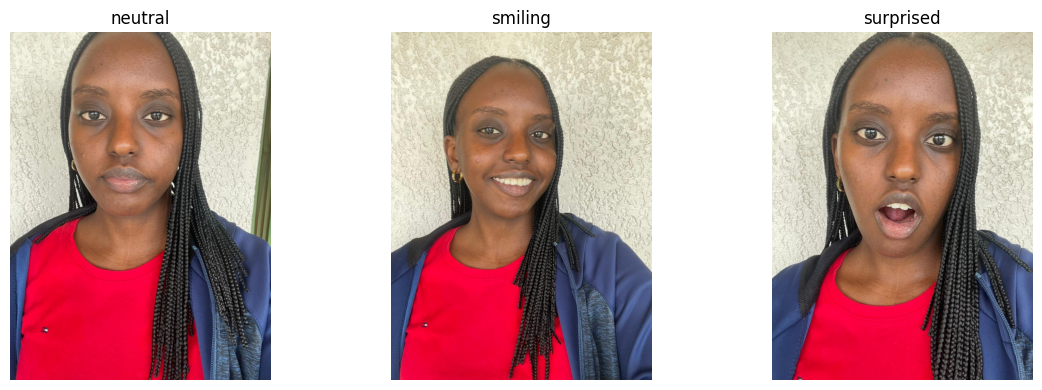


🧑 Showing facial expressions for: Liliane


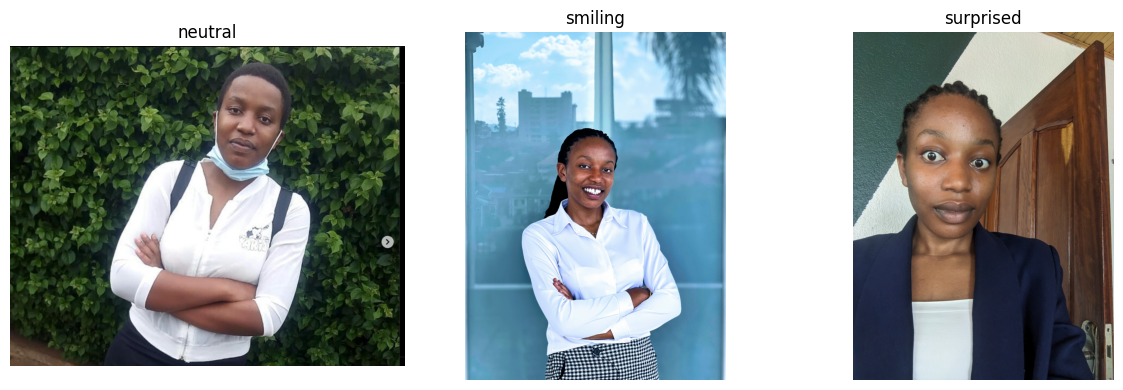


🧑 Showing facial expressions for: Pauline


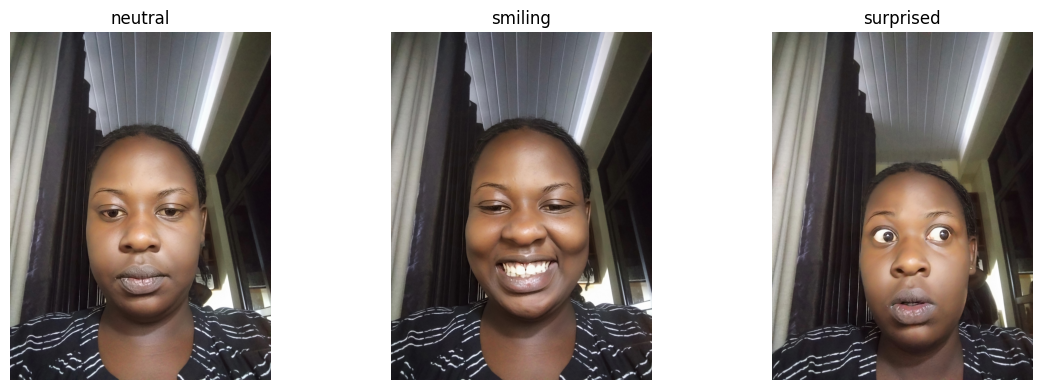

In [2]:

# Displaying images of group members
members = ['Aubert', 'Jade', 'Liliane', 'Pauline']
expressions = ['neutral', 'smiling', 'surprised']

def display_group_images():
    for member in members:
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        print(f"\n🧑 Showing facial expressions for: {member}")
        for i, expression in enumerate(expressions):
            filename = f"./group_images/{member}_{expression}.jpeg"
            if os.path.exists(filename):
                img = cv2.imread(filename)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axs[i].imshow(img)
                axs[i].set_title(f"{expression}", fontsize=12)
                axs[i].axis('off')
            else:
                axs[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
                axs[i].set_title(expression)
                axs[i].axis('off')
        plt.tight_layout()
        plt.show()

display_group_images()

     

In [3]:
# Augmentations function
def augment_image(image):
    # Resize to consistent size
    image = tf.image.resize(image, [224, 224])

    # Horizontal flip
    flipped = tf.image.flip_left_right(image)

    # Rotation (30 degrees)
    rotated = tf.image.rot90(image, k=1)

    # Grayscale
    grayscale = tf.image.rgb_to_grayscale(image)

    return [flipped, rotated, grayscale]

In [4]:
def save_image(tensor, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)  # ✅ ensure dir exists
    array = tf.cast(tensor * 255.0, tf.uint8).numpy()
    if array.shape[-1] == 1:
        array = array.squeeze(-1)
    img = Image.fromarray(array)
    img.save(path)


In [5]:
def augment_and_save_tf(output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for member in members:
        for expression in expressions:
            filename = f"./group_images/{member}_{expression}.jpeg"
            if os.path.exists(filename):
                img_path = filename

                # Load image
                image = tf.io.read_file(img_path)
                image = tf.image.decode_image(image, channels=3)
                image = tf.image.convert_image_dtype(image, tf.float32)

                # Apply augmentations
                augmented = augment_image(image)

                # Save augmented versions (save flat under output_dir)
                base_name = os.path.splitext(os.path.basename(filename))[0]
                for i, aug in enumerate(augmented):
                    aug_filename = f"{base_name}_aug{i}.png"
                    save_path = os.path.join(output_dir, aug_filename)
                    save_image(aug, save_path)
                print(f"Augmented: {filename}")
            else:
                print(f"Not found: {filename}")


In [6]:
# Run augmentation and save
augment_and_save_tf("augmented_images")

Augmented: ./group_images/Aubert_neutral.jpeg
Augmented: ./group_images/Aubert_smiling.jpeg
Augmented: ./group_images/Aubert_surprised.jpeg
Augmented: ./group_images/Jade_neutral.jpeg
Augmented: ./group_images/Jade_smiling.jpeg
Augmented: ./group_images/Jade_surprised.jpeg
Augmented: ./group_images/Liliane_neutral.jpeg
Augmented: ./group_images/Liliane_smiling.jpeg
Augmented: ./group_images/Jade_neutral.jpeg
Augmented: ./group_images/Jade_smiling.jpeg
Augmented: ./group_images/Jade_surprised.jpeg
Augmented: ./group_images/Liliane_neutral.jpeg
Augmented: ./group_images/Liliane_smiling.jpeg
Augmented: ./group_images/Liliane_surprised.jpeg
Augmented: ./group_images/Pauline_neutral.jpeg
Augmented: ./group_images/Liliane_surprised.jpeg
Augmented: ./group_images/Pauline_neutral.jpeg
Augmented: ./group_images/Pauline_smiling.jpeg
Augmented: ./group_images/Pauline_surprised.jpeg
Augmented: ./group_images/Pauline_smiling.jpeg
Augmented: ./group_images/Pauline_surprised.jpeg


In [7]:
# Feature extractor using MobileNetV2

mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
root_dir = '.'
augmented_folder = 'augmented_images'

def load_and_preprocess_image(img_path):
    img = Image.open(img_path).resize((224, 224))
    img_array = np.array(img)

    if img_array.ndim == 2:
        img_array = np.stack((img_array,) * 3, axis=-1)
    elif img_array.shape[-1] == 1:
        img_array = np.repeat(img_array, 3, axis=-1)

    img_array = preprocess_input(img_array.astype(np.float32))
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


In [8]:
# Diagnostic: list augmented files and summarize processing
import os
from collections import Counter

print('augmented_folder:', augmented_folder)
if not os.path.exists(augmented_folder):
    print('Folder not found:', augmented_folder)
else:
    all_pngs = []
    for root, _, files in os.walk(augmented_folder):
        for f in files:
            if f.lower().endswith('.png'):
                p = os.path.join(root, f)
                all_pngs.append(p)
                print(' -', p)
    print(f'\nTotal PNG files found: {len(all_pngs)}')

    # Summarize in-memory extraction results if present
    try:
        feats_len = len(features)
        labels_len = len(labels)
        print(f'\nIn-memory: features={feats_len}, labels={labels_len}')
        names = [str(l).split('_')[0] if '_' in str(l) else str(l) for l in labels]
        print('\nCounts by name (from labels list):')
        print(Counter(names))
    except NameError:
        print('\nNo in-memory `features` / `labels` variables found in this kernel. Run extraction cell first.')

    # If CSV exists, show a quick preview
    csv_path = 'image_features.csv'
    if os.path.exists(csv_path):
        import pandas as pd
        df = pd.read_csv(csv_path)
        print(f"\nCSV '{csv_path}' rows: {len(df)}")
        print(df.head())
        if 'image' in df.columns:
            names_csv = [str(x).split('_')[0] if '_' in str(x) else str(x) for x in df['image']]
            print('\nCounts by name (from CSV image column):')
            print(Counter(names_csv))
    else:
        print(f"\nNo CSV found at {csv_path} (yet).")


augmented_folder: augmented_images
 - augmented_images\Aubert_neutral_aug0.png
 - augmented_images\Aubert_neutral_aug1.png
 - augmented_images\Aubert_neutral_aug2.png
 - augmented_images\Aubert_smiling_aug0.png
 - augmented_images\Aubert_smiling_aug1.png
 - augmented_images\Aubert_smiling_aug2.png
 - augmented_images\Aubert_surprised_aug0.png
 - augmented_images\Aubert_surprised_aug1.png
 - augmented_images\Aubert_surprised_aug2.png
 - augmented_images\Jade_neutral_aug0.png
 - augmented_images\Jade_neutral_aug1.png
 - augmented_images\Jade_neutral_aug2.png
 - augmented_images\Jade_smiling_aug0.png
 - augmented_images\Jade_smiling_aug1.png
 - augmented_images\Jade_smiling_aug2.png
 - augmented_images\Jade_surprised_aug0.png
 - augmented_images\Jade_surprised_aug1.png
 - augmented_images\Jade_surprised_aug2.png
 - augmented_images\Liliane_neutral_aug0.png
 - augmented_images\Liliane_neutral_aug1.png
 - augmented_images\Liliane_neutral_aug2.png
 - augmented_images\Liliane_smiling_aug0.png

In [9]:
# Clean re-extraction: produce `image_features_clean.csv` and a compressed `.npz` for training
import os
import numpy as np
import pandas as pd
import traceback

print('Starting clean feature extraction...')

features = []
labels = []
filenames = []

# 1) Originals (label = person name)
for member in members:
    for expression in expressions:
        path = f"./group_images/{member}_{expression}.jpeg"
        if os.path.exists(path):
            try:
                img = load_and_preprocess_image(path)
                fv = mobilenet.predict(img)[0]
                features.append(fv)
                labels.append(member)                # identity label
                filenames.append(f"{member}_{expression}.jpeg")
            except Exception as e:
                print(f"Error on original {path}: {e}")
                traceback.print_exc()
        else:
            print(f"Original not found: {path}")

# 2) Augmented images (infer person by filename prefix)
for root, _, files in os.walk(augmented_folder):
    for f in files:
        if f.lower().endswith('.png'):
            p = os.path.join(root, f)
            try:
                img = load_and_preprocess_image(p)
                fv = mobilenet.predict(img)[0]
                features.append(fv)
                inferred = str(f).split('_')[0]
                labels.append(inferred)
                filenames.append(f)
            except Exception as e:
                print(f"Error on augmented {p}: {e}")
                traceback.print_exc()

# 3) Build DataFrame, dedupe by filename, and save
if len(features) == 0:
    print('No features extracted. Check earlier errors.')
else:
    X = np.vstack(features)  # shape: (n_samples, 1280)
    df = pd.DataFrame(X)
    df.insert(0, 'filename', filenames)
    df.insert(1, 'label', labels)

    before = len(df)
    df = df.drop_duplicates(subset='filename', keep='first').reset_index(drop=True)
    after = len(df)

    csv_out = 'image_features_clean.csv'
    df.to_csv(csv_out, index=False)

    # Save compressed features (exclude filename+label columns)
    features_array = np.vstack(df.iloc[:, 2:].values)
    npz_out = 'image_features_clean.npz'
    np.savez_compressed(npz_out, X=features_array, filenames=df['filename'].values, labels=df['label'].values)

    print(f"Saved {csv_out} ({before} -> {after} rows after dedupe)")
    print(f"Also saved compressed features to {npz_out}")
    # Print counts per identity
    try:
        from collections import Counter
        print('\nCounts by identity (clean CSV):')
        print(Counter(df['label'].values))
    except Exception:
        pass


Starting clean feature extraction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━